In [22]:
%load_ext autoreload
%autoreload 2

In [143]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product

## Visualization Code

In [17]:
def rescale_score_by_abs (score, max_score, min_score):
    """
    Normalize the relevance value (=score), accordingly to the extremal relevance values (max_score and min_score), 
    for visualization with a diverging colormap.
    i.e. rescale positive relevance to the range [0.5, 1.0], and negative relevance to the range [0.0, 0.5],
    using the highest absolute relevance for linear interpolation.
    """
    
    # CASE 1: positive AND negative scores occur --------------------
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur -----------------------------       
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur -----------------------------
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)    
  
      
def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"


def html_heatmap (words, scores, cmap_name="bwr"):
    """
    Return word-level heatmap in HTML format,
    with words being the list of words (as string),
    scores the corresponding list of word-level relevance values,
    and cmap_name the name of the matplotlib diverging colormap.
    """
    
    colormap  = plt.get_cmap(cmap_name)
     
    assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

## LRP Modules

In [6]:
def stabilize(z):
    return z + ((z == 0.).to(z) + z.sign()) * 1e-6


def modified_layer(
        layer,
        transform
):
    """
    This function creates a copy of a layer and modify
    its parameters based on a transformation function 'transform'.
    -------------------
    :param layer: A layer which its parameters are going to be transformed.
    :param transform: A transformation function.
    :return: A new layer with modified parameters.
    """
    new_layer = copy.deepcopy(layer)

    try:
        new_layer.weight = torch.nn.Parameter(transform(layer.weight.float()))
    except AttributeError as e:
        print(e)

    try:
        new_layer.bias = torch.nn.Parameter(transform(layer.bias.float()))
    except AttributeError as e:
        print(e)

    return new_layer


class ModifiedLinear(Module):
    def __init__(
            self,
            fc,
            transform
    ):
        super(ModifiedLinear, self).__init__()
        self.fc = fc
        
        # TODO: Do not set bias to 0.
        # self.fc.bias = torch.nn.Parameter(torch.zeros(self.fc.bias.shape))
        
        self.transform = transform
        self.modified_fc = modified_layer(layer=fc, transform=transform)

    def forward(
            self,
            x: torch.Tensor
    ) -> torch.Tensor:
        z = self.fc(x)
        zp = self.modified_fc(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()

    
class ModifiedLayerNorm(Module):
    def __init__(
            self,
            norm_layer,
            normalized_shape,
            eps=1e-12
    ):
        super(ModifiedLayerNorm, self).__init__()
        # TODO: Do not set bias to 0.
        # norm_layer.bias = torch.nn.Parameter(torch.zeros(norm_layer.bias.shape))
        
        self.norm_layer = norm_layer
        self.weight = norm_layer.weight
        self.bias = norm_layer.bias
        self.normalized_shape = normalized_shape
        self.eps = eps

    def forward(
            self,
            input: torch.Tensor
    ) -> torch.Tensor:

        z = self.norm_layer(input)
        mean = input.mean(dim=-1, keepdim=True)
        var = torch.var(input, unbiased=False, dim=-1, keepdim=True)
        denominator = torch.sqrt(var + self.eps)
        denominator = denominator.detach()
        zp = ((input - mean) / denominator) * self.weight + self.bias
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()
    
class ModifiedAct(Module):
    def __init__(
        self,
        act
    ):
        super(ModifiedAct, self).__init__()
        self.modified_act = nn.Identity()
        self.act = act
    
    def forward(
        self,
        x
    ):
        z = self.act(x)
        zp = self.modified_act(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()
    
class ModifiedTanh(Module):
    def __init__(
        self,
        act
    ):
        super(ModifiedTanh, self).__init__() 
        self.act = act
        self.modified_act = nn.Identity()
    
    def forward(
        self,
        x
    ):
        z = self.act(x)
        zp = self.modified_act(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()

## LRP Rules

In [7]:
def gamma(
        gam: float = 0.0
) -> Tensor:

    def modify_parameters(parameters: Tensor):
        return parameters + (gam * parameters.clamp(min=0))

    return modify_parameters

## BERT Model's Building Blocks

<img src="BERT.png">

## LRP for BERT

In [8]:
class ModifiedBertSelfAttention(nn.Module):
    def __init__(self, self_attention):
        super(ModifiedBertSelfAttention, self).__init__()
        self.query = ModifiedLinear(fc=self_attention.query, transform=gamma())
        self.key = ModifiedLinear(fc=self_attention.key, transform=gamma())
        self.value = ModifiedLinear(fc=self_attention.value, transform=gamma())
        
        self.dropout = self_attention.dropout   
        self.num_attention_heads = self_attention.num_attention_heads
        self.attention_head_size = self_attention.attention_head_size
        self.all_head_size = self_attention.all_head_size
        
    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, hidden_states):
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        query_layer = self.transpose_for_scores(self.query(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        
        # Attention scores
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        attention_probs = nn.Softmax(dim=-1)(attention_scores).detach()
        
        
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)
        outputs = context_layer
        
        return outputs
        
class ModifiedBertSelfOutput(nn.Module): 
    def __init__(self, self_output):
        super(ModifiedBertSelfOutput, self).__init__()
        self.dense = ModifiedLinear(fc=self_output.dense, transform=gamma())
        self.LayerNorm = ModifiedLayerNorm(norm_layer=self_output.LayerNorm,
                                           normalized_shape=self_output.dense.weight.shape[1])
        self.dropout = self_output.dropout
        
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)                
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states
        
    
class ModifiedBertAttention(nn.Module):
    def __init__(self, attention):
        super(ModifiedBertAttention, self).__init__()
        self.self = ModifiedBertSelfAttention(attention.self)
        self.output = ModifiedBertSelfOutput(attention.output)
        
    def forward(self, hidden_states):
        self_output = self.self(hidden_states)
        attention_output = self.output(self_output, hidden_states)
        
        return attention_output
        
        
class ModifiedBertIntermediate(nn.Module):
    def __init__(self, intermediate):
        super(ModifiedBertIntermediate, self).__init__()
        self.dense = ModifiedLinear(fc=intermediate.dense, transform=gamma())
        self.intermediate_act_fn = ModifiedAct(intermediate.intermediate_act_fn)
        
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states  

class ModifiedBertOutput(nn.Module):
    def __init__(self, output):
        super(ModifiedBertOutput, self).__init__()
        self.dense = ModifiedLinear(fc=output.dense, transform=gamma())
        self.LayerNorm = ModifiedLayerNorm(norm_layer=output.LayerNorm,
                                           normalized_shape=output.dense.weight.shape[1])
        self.dropout = output.dropout
        
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)                
        hidden_states = self.LayerNorm(hidden_states + input_tensor) 

        return hidden_states
    
class ModifiedBertLayer(nn.Module):
    def __init__(self, layer):
        super(ModifiedBertLayer, self).__init__()
        self.attention = ModifiedBertAttention(layer.attention)
        # self.intermediate = ModifiedBertIntermediate(layer.intermediate)
        # self.output = ModifiedBertOutput(layer.output)
        self.intermediate = torch.nn.Identity()
        self.output = torch.nn.Identity()
        
    def forward(self, hidden_states):
        attention_output = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        hidden_states = self.output(intermediate_output, attention_output)
        
        return hidden_states

# -------- Second-Order --------
class ModifiedBertLayerHigherOrder(nn.Module):
    def __init__(self, layer):
        super(ModifiedBertLayerHigherOrder, self).__init__()
        self.attention = ModifiedBertAttention(layer.attention)
        
    def forward(self, hidden_states, mask):
        z = attention_output = self.attention(hidden_states)
        z = z * mask + z.data * (1 - mask)
        return z
# -----------------------------
        
class ModifiedBertEncoder(nn.Module):
    def __init__(self, encoder, order):
        super(ModifiedBertEncoder, self).__init__()
        self.order = order
        layers = []
        
        n = len(encoder.layer)
        for i, layer in enumerate(encoder.layer):
            if order == 'higher':
                # Mask all layers.
                layers.append(ModifiedBertLayerHigherOrder(layer))
            else:
                layers.append(ModifiedBertLayer(layer))
        self.layer = nn.ModuleList(layers)
        
    def forward(self, hidden_states):        
        for i, layer in enumerate(self.layer):
            hidden_states = layer(hidden_states)      
        return hidden_states
    
class ModifiedBertPooler(nn.Module):
    def __init__(self, pooler):
        super(ModifiedBertPooler, self).__init__()
        self.dense = ModifiedLinear(fc=pooler.dense, transform=gamma())
        self.activation = ModifiedTanh(pooler.activation)
        
    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        
        return pooled_output

class ModifiedBertModel(nn.Module):
    def __init__(self, bert, embeddings, order):
        super(ModifiedBertModel, self).__init__()
        self.embeddings = embeddings
        self.encoder = ModifiedBertEncoder(bert.encoder, order)
        self.pooler = ModifiedBertPooler(bert.pooler)
        
    def forward(self, x):
        hidden_states = self.embeddings(x)    
        hidden_states = self.encoder(hidden_states)
        hidden_states = self.pooler(hidden_states)
        
        return hidden_states
    
class ModifiedBertForSequenceClassification(nn.Module):
    def __init__(self, bert_classification, embeddings, order='higher'):
        super(ModifiedBertForSequenceClassification, self).__init__()
        self.bert = ModifiedBertModel(bert_classification.bert, embeddings, order)
        self.dropout = bert_classification.dropout
        self.classifier = ModifiedLinear(fc=bert_classification.classifier, transform=gamma())
        self.order = order
        
    def forward(self, x):
        hidden_states = self.bert(x)
        hidden_states = self.classifier(hidden_states)
        
        return hidden_states

## XAI Utils

In [9]:
def symb_xai(rels, feats, mode='subset'):
    assert mode in ['subset', 'and', 'or', 'not'], f'Mode "{mode}" is not implemented.'
    r = 0.
    for w, rel in rels.items():
        if mode == 'subset' and all([token in feats for token in w ]):
            r += rel
        elif mode == 'and' and all([ token in w for token in feats ]):
            r += rel
        elif mode == 'or' and any([ token in w for token in feats]):
            r += rel
        elif mode == 'not' and all([ token not in w for token in feats]):
            r += rel
    return r

## LRP for BERT

In [10]:
def lrp(model, x, target, indices, pretrained_embeddings):
    A = {}
    
    hidden_states = pretrained_embeddings(input_ids=x['input_ids'], token_type_ids=x['token_type_ids'])
    A['hidden_states'] = hidden_states
    attn_input = hidden_states
    
    if model.order == 'higher':
        M = torch.eye(hidden_states.shape[1])
        j, k, l = indices
        Mj = M[j].unsqueeze(0).unsqueeze(2)
        Mk = M[k].unsqueeze(0).unsqueeze(2)
        Ml = M[l].unsqueeze(0).unsqueeze(2)
        
    n = len(model.bert.encoder.layer)
    for i, layer in enumerate(model.bert.encoder.layer):
            attn_inputdata = attn_input.data
            attn_inputdata.requires_grad_(True) 
                        
            A['attn_input_{}_data'.format(i)] = attn_inputdata
            A['attn_input_{}'.format(i)] = attn_input
            
            if model.order == 'higher':
                if i == n-1:
                    output = model.bert.encoder.layer[i](A['attn_input_{}_data'.format(i)], Mj)
                elif i == n-2:
                    output = model.bert.encoder.layer[i](A['attn_input_{}_data'.format(i)], Mk)
                elif i == n-3:
                    output = model.bert.encoder.layer[i](A['attn_input_{}_data'.format(i)], Ml)  
            else:
                output = model.bert.encoder.layer[i](A['attn_input_{}_data'.format(i)])
            attn_input = output
            
    outputdata = output.data
    outputdata.requires_grad_(True)
    
    pooled = model.bert.pooler(outputdata)
    pooleddata = pooled.data
    pooleddata.requires_grad_(True) 
        
    logits = model.classifier(pooleddata)
    pred = torch.argmax(logits)
    Rout = (logits * target).sum()
    
    Rout.backward()
    ((pooleddata.grad)*pooled).sum().backward()
                
    Rpool = ((outputdata.grad)*output)
    R_ = Rpool
    
    R_all = []
    for i, layer in list(enumerate(model.bert.encoder.layer))[::-1]:
        R_.sum().backward()
        R_grad = A['attn_input_{}_data'.format(i)].grad
        R_attn =  (R_grad)*A['attn_input_{}'.format(i)]
        
        R_ = R_attn
        R_all.append(R_.sum(2).detach().cpu().numpy().squeeze().sum())

    R = R_.sum(2).detach().cpu().numpy()
    
    return R, pred, Rout, R_all

## BERT model with 3 layers

In [12]:
params = torch.load('sst2-3layer-model.pt', map_location=torch.device('cpu'))

model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")
model.bert.encoder.layer = model.bert.encoder.layer[:3]

model.bert.encoder.layer[0].intermediate = torch.nn.Identity()
model.bert.encoder.layer[1].intermediate = torch.nn.Identity()
model.bert.encoder.layer[2].intermediate = torch.nn.Identity()

model.bert.encoder.layer[0].output = torch.nn.Identity()
model.bert.encoder.layer[1].output = torch.nn.Identity()
model.bert.encoder.layer[2].output = torch.nn.Identity()

state_dict = model.state_dict()   

for i in range(3):
    state_dict['bert.encoder.layer.{}.attention.self.query.weight'.format(i)] = params['attention_layers.{}.query.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.weight'.format(i)] = params['attention_layers.{}.key.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.weight'.format(i)] = params['attention_layers.{}.value.weight'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.self.query.bias'.format(i)] = params['attention_layers.{}.query.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.bias'.format(i)] = params['attention_layers.{}.key.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.bias'.format(i)] = params['attention_layers.{}.value.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.dense.weight'.format(i)] = params['attention_layers.{}.output.dense.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.dense.bias'.format(i)] = params['attention_layers.{}.output.dense.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.weight'.format(i)] = params['attention_layers.{}.output.LayerNorm.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.bias'.format(i)] = params['attention_layers.{}.output.LayerNorm.bias'.format(i)]
    
    state_dict['bert.pooler.dense.weight'] = params['pooler.dense.weight']
    state_dict['bert.pooler.dense.bias'] = params['pooler.dense.bias']
    
    state_dict['classifier.weight'] = params['classifier.weight']
    state_dict['classifier.bias'] = params['classifier.bias']

In [13]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Explain tiny BERT model on the SST2 dataset

In [86]:
# num_data = 0
# relevance = []
# relevance_all = []
# logits = []
# acc = 0


class HOExplainer:
    def __init__(self, model):
        self.pretrained_embeddings = model.bert.embeddings
        self.modified_model = ModifiedBertForSequenceClassification(model,
                                                       pretrained_embeddings,
                                                       order='higher')
        self.modified_model.eval()

        self.tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
        self.UNK_IDX = tokenizer.unk_token_id  # an out-of-vocab token
        
    def setup_sample(self,sentence, target):
        self.sentence = sentence
        self.target = target
        self.x = tokenizer(sentence, return_tensors="pt")
        self.words = tokenizer.convert_ids_to_tokens(self.x['input_ids'].squeeze())
        
        return True
    
    def explain(self):
        rels = {}
        set(product(range(len(self.words)),repeat = 4))
        combinations = set(product(range(len(self.words)),repeat = 4))
        for (i, j, k, l) in combinations:
            indices = (j, k, l)
            R, pred, logit, R_all = lrp(self.modified_model, self.x, self.target, indices, self.pretrained_embeddings)
            rels[(i, j, k, l)] = R.squeeze()[i].sum()
        
        return rels



In [147]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    words = list(dataset.vocab.keys())

def make_text_string(lsent):
    sentence = ''
    for i, token in enumerate(lsent):
        if token not in [',', '.', ';', ':', "n't", "'s", "''", "'d", "'re"] and i != 0 and sentence[-2:] != "``" :
            sentence += ' '
        sentence += token
        
    return sentence


In [169]:
i = 4
go = False

if mode == 'huggingface':
    sentence = dataset['validation']['sentence'][i]
    label = dataset['validation']['label'][i]
    
#     target = torch.nn.functional.one_hot(
#                 torch.tensor(label), num_classes=2)

elif mode == 'treebank':
    tree = dataset[i]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
    adj= tree.adj()
    
    lsent = [ words[idw] for idw in input_ids[mask == 1]]
    sentence = make_text_string(lsent)
    
    label = labels[0] 
        
target = torch.tensor([-1,1])

print(sentence)

explainer = HOExplainer(model)
explainer.setup_sample(sentence,target)
print('nb_tokens:', len(explainer.words), explainer.words, lsent)
if go: rels = explainer.explain()


yet the act is still charming here.
nb_tokens: 10 ['[CLS]', 'yet', 'the', 'act', 'is', 'still', 'charming', 'here', '.', '[SEP]'] ['yet', 'the', 'act', 'is', 'still', 'charming', 'here', '.']


In [145]:
len(rels)

10000

/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_3704/3775037019.py:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


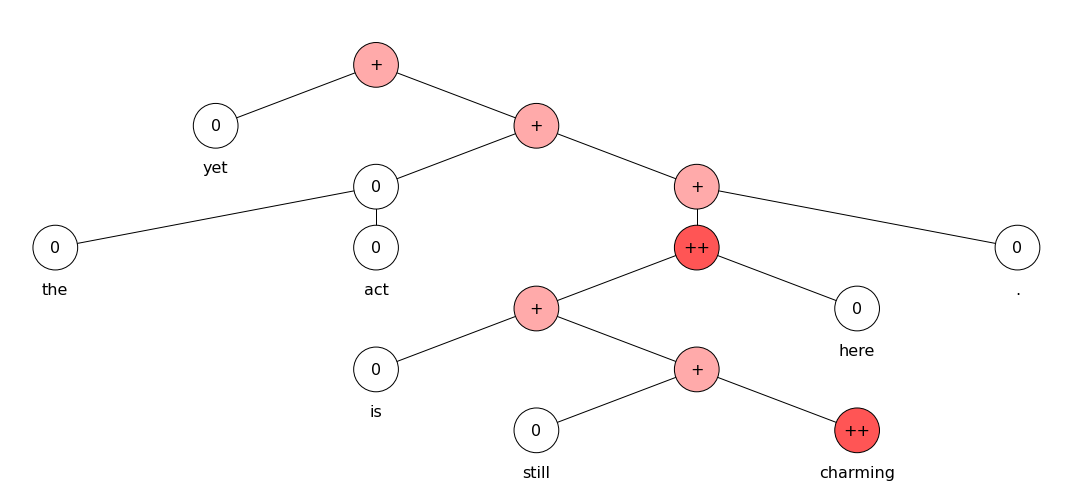

In [225]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from xai_utils import make_color


def vis_tree_heat(tree, node_heat, node_labels=None ):
    plt.figure(figsize=[15,7])

    G = dgl.to_networkx(tree)
    G = G.to_undirected()
    pos = graphviz_layout(G, prog="dot")

    # nodes
    nx.draw_networkx_nodes(G, pos, 
                           node_color = node_heat,
                           edgecolors = 'black', 
                           node_size=2000)

    # labels
    if node_labels is not None:
        nx.draw_networkx_labels(G, pos, 
                            labels =node_labels,
                           font_size=16)

    # edges
    nx.draw_networkx_edges(G,pos)
    
    # words
    leaf_nodes = mask.nonzero().squeeze().numpy()
    pos_ = copy.copy(pos)
    
    for ln in leaf_nodes: pos_[ln] = (pos_[ln][0], pos_[ln][1] -50)

    nx.draw_networkx_labels(G, pos_, 
                            labels = {ln: words[idw] for ln, idw in zip(leaf_nodes,input_ids[mask == 1])},
                           font_size=16)

    plt.axis('off')
    plt.tight_layout()
    plt.margins(y=.1, x=.0)
    plt.show()

# plot ground truth
label2sent_symb = {0:'--', 1: '-', 2:'0', 3: '+', 4:'++'}
node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

vis_tree_heat(tree, node_heat, node_labels=node_labels)


/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_3704/3775037019.py:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


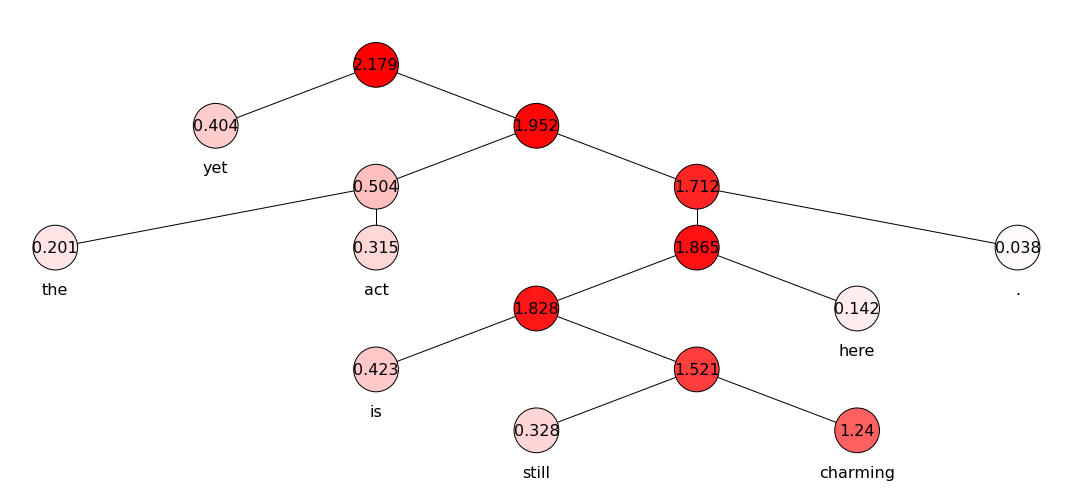

In [242]:
# plot relevance
def process_treeid2tokenid(indices, mask, tokens=None, lsent=None):
    
    treeInd2token = { int(treei) : tokeni+1 for tokeni, treei in enumerate(mask.nonzero().squeeze())}
    token_indices = set([ treeInd2token[ind] for ind in indices 
                         if ind in mask.nonzero().squeeze() ]) 
    
#     token_indices.add(0) # always add '[CLS]' 
    
    return token_indices


G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask)
    
    node_rels[node_id] = symb_xai(rels, token_set, mode='or')
#     node_labels[node_id] = [explainer.words[token] for token in token_set]
    
node_heat = [make_color( rel, scaling=.5) for rel in node_rels.values() ]
# node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }
node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, node_heat, node_labels=node_labels)
# print(node_rels)

(1.0463390209552017, 1.0463390209552017)

In [ ]:
# problem:
# 1) too slow - ok
# 2) only leaf nodes that are in the ancestors are present can be interpreted by the releance scores  - ok 
# 3) word label is shifted, right? - ok

In [24]:
from xai_utils import create_text_heat_map
print("------------------")
print("Effect of feature 'bleak':")
R = np.zeros(len(words))
R_6 = symb_xai(rels, (6,), mode='and')
R[6] = R_6
print('rel', R_6)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Effect of feature 'desperate':")
R = np.zeros(len(words))
R_8 = symb_xai(rels, (8,), mode='and')
R[8] = R_8
print('rel', R_8)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Joint effect of features 'bleak' and 'desperate':")
R = np.zeros(len(words))
R_68 = symb_xai(rels, (6, 8), mode='and')
R[6] = R_68
R[8] = R_68
print('rel', R_68)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

print("------------------")
print("Joint effect of features 'bleak', 'and', and 'desperate':")
R = np.zeros(len(words))
R_678 = symb_xai(rels, (6, 7, 8), mode='and')
R[6] = R_678
R[7] = R_678
R[8] = R_678
print('rel', R_678)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

------------------
Effect of feature 'bleak':
rel 0.1797429032326363


------------------
Effect of feature 'desperate':
rel 0.2802975700337811


------------------
Joint effect of features 'bleak' and 'desperate':
rel 0.02442454126503435


------------------
------------------
Joint effect of features 'bleak', 'and', and 'desperate':
rel 0.000545854516531108


------------------
